In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, desc, func, inspect, MetaData, Table

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Exploring columns in measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Exploring columns in station table
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

- Design a query to retrieve the last 12 months of precipitation data and plot the results

- Calculate the date 1 year ago from the last data point in the database

- Perform a query to retrieve the data and precipitation scores

- Save the query results as a Pandas DataFrame and set the index to the date column

- Sort the dataframe by date

- Use Pandas Plotting with Matplotlib to plot the data


In [12]:
# Examine data in measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [18]:
# Retrieve Date and Precipitation Scores
rain_dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

In [45]:
# save results to dataframe
df = pd.DataFrame(rain_dates)
df = df.sort_values(['date'])
df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


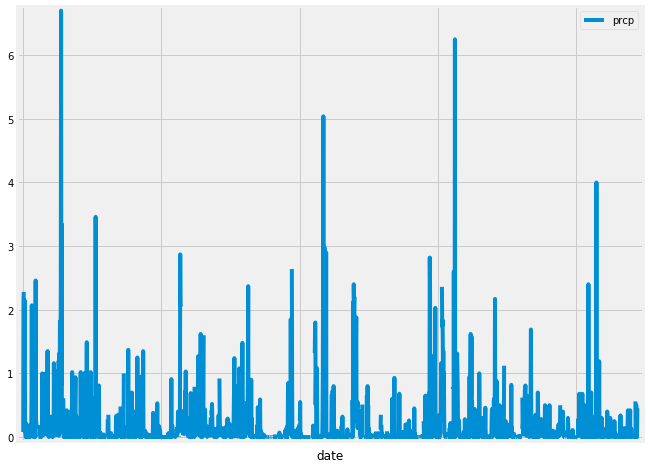

In [46]:
# Plot the Results in a Matplotlib bar chart
df.set_index('date', inplace=True)
fig, ax = plt.subplots(figsize=(10,8))
ax.margins(x=.01, y=.01) 
df.plot(ax=ax)

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [48]:
# Design a query to show how many stations are available in this dataset?
engine.execute('SELECT count(station) FROM station').fetchall()

[(9,)]

In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations = session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc())
stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

- USC00519281 has the highest number of observations

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [51]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.tobs != None).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
station_temps.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Query for just temperatures
all_temps = session.query(Measurement.tobs).filter(Measurement.date > '2016-08-23', Measurement.station == 'USC00519281').all()

In [53]:
all_temps = [temp[0] for temp in all_temps]

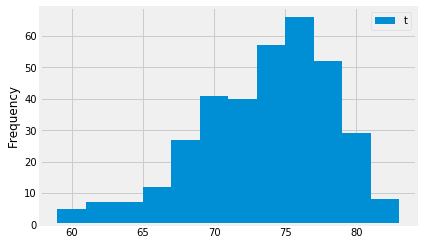

In [54]:
plt.hist(all_temps, 12)
plt.ylabel("Frequency")
plt.legend("tobs")
plt.show()

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_temps = calc_temps('2017-06-11','2017-06-18')
temps = []
for item in vacation_temps[0]:
    temps.append(item)
temps

[72.0, 77.03846153846153, 83.0]

<BarContainer object of 1 artists>

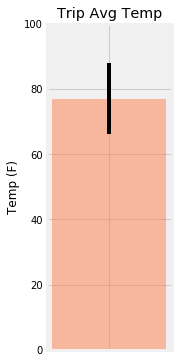

In [57]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# bar width
y = [temps[1]]

fig, ax = plt.subplots(figsize=(2,6))
ax.set_ylim([0, 100])
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.bar('',y,
       yerr=(temps[2]-temps[0]),    # error bars
       capsize=0,
       width=2,align='center',color='coral', alpha=.5
      )
